### Sayan Patra's code:

In [1]:
import matplotlib.pyplot as plt, numpy as np, numpy.random as npr, matplotlib.pyplot as plt, pickle
from tqdm import trange
import scipy, pystan as ps
%matplotlib inline
from time import time
from pylab import plot, show, legend

#### Compile Stan model:

In [2]:
sm = ps.StanModel(file="brain_sayan.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_645c49c27c38e30a11e728857617fbb0 NOW.


#### Load data from file and prepare stan data list:

In [3]:
from numpy import loadtxt

X = np.zeros((42,68,68))
for i in range(42) :
    name = "/home/postdoc/dsen/Desktop/projeted_posterior/brain_data/data_column"+str(i+1)
    X[i] = loadtxt(name, comments="#", delimiter=" ", unpack=False)
X = X.astype(int)

# N = 21 
# m = np.shape(X)[1]
# p = 10
# a = 1/m
# data = dict(N=N, m=m, p=p, X=X[:N], alpha=1/m, lmbda=0.5)

N = 21 
m = 68
p = 10
data = dict(N=N, m=m, p=p, X=X[:N,:m,:m], alpha=1./m)

print(np.mean(X[:N,:m,:m]))

0.3557422969187675


#### Initialise parameters for sampling:

In [4]:
Z_ini = npr.randn(m,m)
pp = np.mean(X[:N,:m,:m],0)
pp[pp==0] = 0.01
pp[pp==1] = 0.99

eg_p = np.linalg.eig(np.log(pp/(1-pp)))
U_ini = eg_p[1][:,:p]
D_ini = np.transpose(np.reshape(np.ravel([np.abs(eg_p[0][:p])]*N), (p,N), order='C'))

etaU_ini= npr.rand(m,p)
sigsqZ_ini = npr.rand()
sigsqD_ini = npr.rand(p)

def initfun():
    return dict(Z=Z_ini, U=U_ini, D=D_ini, etaU=etaU_ini, sigsqZ=sigsqZ_ini, sigsqD=sigsqD_ini)

#### Sample using stan:

In [5]:
control = dict(max_treedepth=10)
start = time()
fit = sm.sampling(data=data, thin=1, n_jobs=10, chains=10, iter=2_000, init=initfun, control=control)
print(round((time()-start)/60,2), "minutes to run")
print(fit)
trace = fit.extract()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


715.46 minutes to run
Inference for Stan model: anon_model_645c49c27c38e30a11e728857617fbb0.
10 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=10000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Z[1,1]        0.21    0.22   0.58  -0.66  -0.22   0.11   0.46   1.49      7   3.61
Z[2,1]       -0.62    0.24   0.62  -2.02  -1.07  -0.46  -0.18   0.26      7   2.89
Z[3,1]        0.98    0.18   0.51   0.15   0.62   0.91   1.28   2.28      8   1.97
Z[4,1]        0.57    0.23   0.59  -0.69   0.16   0.58   1.01   1.51      7   2.31
Z[5,1]       -0.29    0.18   0.55  -1.45  -0.65  -0.29   0.05   0.81      9   1.86
Z[6,1]       -1.26    0.22   0.56  -2.56  -1.55  -1.25  -0.88  -0.25      7   2.46
Z[7,1]       -0.27    0.14   0.46  -1.03  -0.62  -0.36   0.12   0.54     11   2.03
Z[8,1]       -0.34    0.22   0.62  -1.67  -0.69  -0.25  -0.02   1.01      8   2.44
Z[9,1]       -0.44    0.19    0.5  -1.31

#### Plot posterior means of $U$'s:

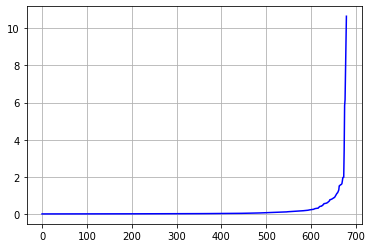

In [6]:
plt.plot(np.sort(np.abs(np.mean(trace['U'],0)).flatten()), 'b-')
plt.grid(True)

#### Save data:

In [7]:
name = '/xtmp/projected_posterior_data/brain_analysis/MCMC_output/trace_DL'
with open(name + '.pkl', 'wb') as f:
    pickle.dump(trace, f, pickle.HIGHEST_PROTOCOL)

In [8]:
for i in range(p) :
    np.savetxt('/xtmp/projected_posterior_data/brain_analysis/MCMC_output/U'+str(i+1)+'.txt', 
               trace['U'][:,:,i], delimiter=',')

### Read data:

In [9]:
name = '/xtmp/projected_posterior_data/brain_analysis/MCMC_output/trace_DL'
with open(name + '.pkl', 'rb') as f: trace = pickle.load(f)

#### Project using SVD:

In [10]:
def project(U) :
    m, p = np.shape(U)
    assert p <= m
    A, _, B = np.linalg.svd(U)
    proj = np.zeros(np.shape(U))
    for i in range(p) :
        proj += np.matmul(np.reshape(A[:,i],(m,1)),np.reshape(B[i],(1,p)))
    return proj

In [24]:
Nsamples = np.shape(trace['U'])[0]
projU = np.zeros(np.shape(trace['U']))
projD = np.zeros(np.shape(trace['D']))
for i in range(Nsamples) :
    projU[i] = project(trace['U'][i])
    for n in range(np.shape(trace['D'])[1]) :
        projD[i,n] = trace['D'][i,n]*np.linalg.norm(trace['U'][i], ord=2)**2

#### Plot log-likelihoods of posterior samples:

In [25]:
def log_ll(X, Z, U, D) :
    ll = 0
    N = np.shape(X)[0]
    for n in range(N) :
        ZUDU = Z + np.matmul(np.matmul(U, np.diag(D[n])), U.transpose())
        probs = 1/(1+np.exp(-ZUDU))
        probs[probs==1] = 1-1e-10
        probs[probs==0] = 1e-10
        ll += np.sum(X[n]*np.log(probs) + (1-X[n])*np.log(1-probs))
    return ll

/auto/pkg/python-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


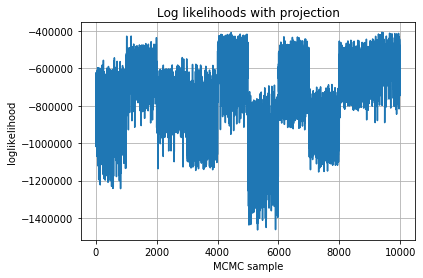

In [26]:
log_lls_proj = [log_ll(X[:N,:m,:m], trace['Z'][i], projU[i], projD[i]) for i in range(Nsamples)]

plt.plot(log_lls_proj)
plt.grid(True)
plt.title("Log likelihoods with projection");
plt.xlabel("MCMC sample");
plt.ylabel("loglikelihood");

/auto/pkg/python-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


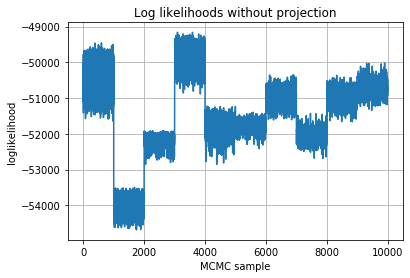

In [27]:
log_lls_noproj = [log_ll(X[:N,:m,:m], trace['Z'][i], trace['U'][i], trace['D'][i]) for i in range(Nsamples)]

plt.plot(log_lls_noproj)
plt.grid(True)
plt.title("Log likelihoods without projection");
plt.xlabel("MCMC sample");
plt.ylabel("loglikelihood");

#### Out of sample log likelihood:

/auto/pkg/python-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


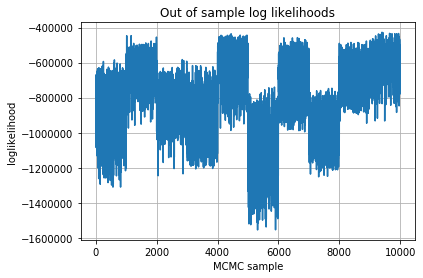

In [15]:
log_lls_oos = [log_ll(X[N:,:m,:m], trace['Z'][i], projU[i], projD[i]) for i in range(Nsamples)]
plt.plot(log_lls_oos)
plt.grid(True)
plt.title("Out of sample log likelihoods");
plt.xlabel("MCMC sample");
plt.ylabel("loglikelihood");